In [2]:
%config IPCompleter.greedy=True;

In [ ]:
"""
TODOs:
    1. Explore pm2.5 by days
    2. Generally explore values by days.
"""

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
import numpy as np
from timeit import default_timer as timer

In [7]:
dataFile = "../data/beijing_pm25.csv"

In [65]:
# Read data file.
df = pd.read_csv(dataFile,sep=',')

# Drop rows with NaN values in target column pm2.5
sizeBefore = df.shape[0]
df = df.dropna()
nanCount = sizeBefore - df.shape[0]
print(f"Initial dataset with {df.shape[0]} rows and {df.shape[1]} columns, dropped {nanCount} NaN rows")

Initial dataset with 41757 rows and 13 columns, dropped 2067 NaN rows


In [67]:
# Add week days column
dates = pd.to_datetime(df[["day", "month","year", "hour"]])
week_days = [d.isoweekday() for d in dates]
df["week_day"] = week_days

In [68]:
# Drop No column which is just ID and reorganize columns 
df = df[["week_day","day", "month", "year", "hour", "DEWP", "TEMP", "PRES", "cbwd", "Iws", "Is", "Ir", "pm2.5"]]
# Rename columns to sensible names
df = df.rename({
    "DEWP": "dew_point", 
    "TEMP": "temperature", 
    "PRES": "pressure",
    "cbwd": "wind_direction",
    "Iws": "wind_speed",
    "Is": "hours_snow",
    "Ir": "hours_rain"}, axis=1)

In [132]:
df

,week_day,day,month,year,hour,dew_point,temperature,pressure,wind_direction,wind_speed,hours_snow,hours_rain,pm2.5
24,6,2,1,2010,0,-16,-4.0,1020.0,SE,1.79,0,0,129.0
25,6,2,1,2010,1,-15,-4.0,1020.0,SE,2.68,0,0,148.0
26,6,2,1,2010,2,-11,-5.0,1021.0,SE,3.57,0,0,159.0
27,6,2,1,2010,3,-7,-5.0,1022.0,SE,5.36,1,0,181.0
28,6,2,1,2010,4,-7,-5.0,1022.0,SE,6.25,2,0,138.0
29,6,2,1,2010,5,-7,-6.0,1022.0,SE,7.14,3,0,109.0
30,6,2,1,2010,6,-7,-6.0,1023.0,SE,8.93,4,0,105.0
31,6,2,1,2010,7,-7,-5.0,1024.0,SE,10.72,0,0,124.0
32,6,2,1,2010,8,-8,-6.0,1024.0,SE,12.51,0,0,120.0
33,6,2,1,2010,9,-7,-5.0,1025.0,SE,14.30,0,0,132.0


In [138]:
# Columns statistics
df.describe()

,week_day,day,month,year,hour,dew_point,temperature,pressure,wind_speed,hours_snow,hours_rain,pm2.5
count,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000,41757.000000
mean,4.001892,15.685514,6.513758,2012.042771,11.502311,1.750174,12.401561,1016.442896,23.866747,0.055344,0.194866,98.613215
std,1.994789,8.785539,3.454199,1.415311,6.924848,14.433658,12.175215,10.300733,49.617495,0.778875,1.418165,92.050387
min,1.000000,1.000000,1.000000,2010.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000,0.000000
25%,2.000000,8.000000,4.000000,2011.000000,5.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000,29.000000
50%,4.000000,16.000000,7.000000,2012.000000,12.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000,72.000000
75%,6.000000,23.000000,10.000000,2013.000000,18.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000,137.000000
max,7.000000,31.000000,12.000000,2014.000000,23.000000,28.000000,42.000000,1046.000000,565.490000,27.000000,36.000000,994.000000


In [103]:
# Week day analysis
weekDaysDf = pd.DataFrame(df["week_day"].value_counts())
weekDaysDf = weekDaysDf.sort_index()
weekDaysDf
# df["week_day"].hist(bins=7)

,week_day
1,5923
2,5932
3,5989
4,6011
5,6019
6,5967
7,5916


<BarContainer object of 7 artists>

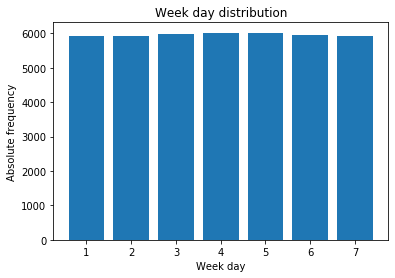

In [120]:
plt.title("Week day distribution")
plt.xlabel("Week day")
plt.ylabel("Absolute frequency")
plt.bar(weekDaysDf.index.values, weekDaysDf.week_day.values)

In [121]:
# Month analysis
monthDf = pd.DataFrame(df["month"].value_counts())
monthDf = monthDf.sort_index()
monthDf

,month
1,3471
2,3373
3,3556
4,3405
5,3609
6,3405
7,3647
8,3337
9,3333
10,3579


<BarContainer object of 12 artists>

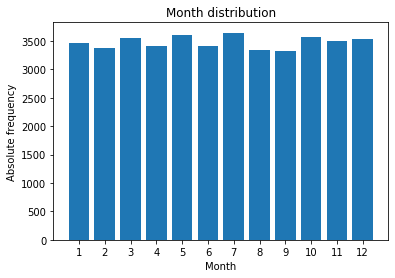

In [126]:
plt.title("Month distribution")
plt.xlabel("Month")
plt.ylabel("Absolute frequency")
plt.xticks(monthDf.index.values)
plt.bar(monthDf.index.values, monthDf.month.values)

In [127]:
# Year analysis
yearDf = pd.DataFrame(df["year"].value_counts())
yearDf = yearDf.sort_index()
yearDf

,year
2010,8091
2011,8032
2012,8295
2013,8678
2014,8661


<BarContainer object of 5 artists>

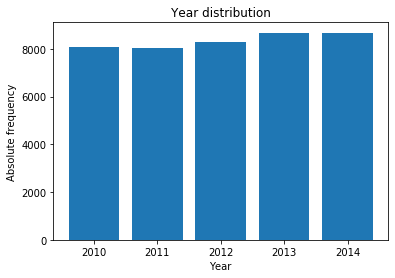

In [133]:
plt.title("Year distribution")
plt.xlabel("Year")
plt.ylabel("Absolute frequency")
plt.xticks(yearDf.index.values)
plt.bar(yearDf.index.values, yearDf.year.values)

In [210]:
# Wind direction analysis
#set(df["wind_direction"])
windDirDf = pd.DataFrame(df["wind_direction"].value_counts())
windDirDf = windDirDf.sort_index()
windDirDf

,wind_direction
NE,4756
NW,13484
SE,14573
cv,8944


<BarContainer object of 4 artists>

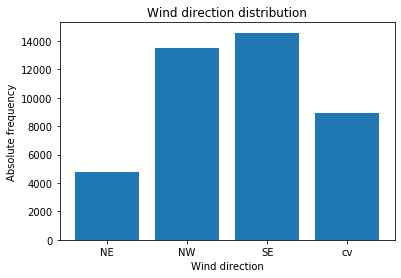

In [215]:
plt.title("Wind direction distribution")
plt.xlabel("Wind direction")
plt.ylabel("Absolute frequency")
plt.bar(windDirDf.index.values,windDirDf.wind_direction.values)

In [183]:
def outlier_count(boxplot_object):    
    assert len(boxplot_object["fliers"]) == 1
    yData =  boxplot_object["fliers"][0].get_ydata()
    outlierCount = len(yData)
    return outlierCount

dew_point outlier count 0 out of 41757


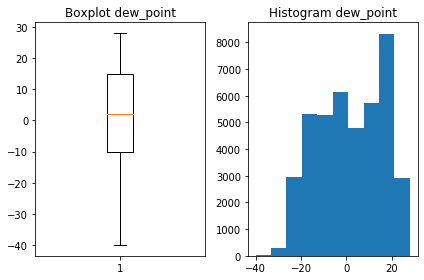

temperature outlier count 0 out of 41757


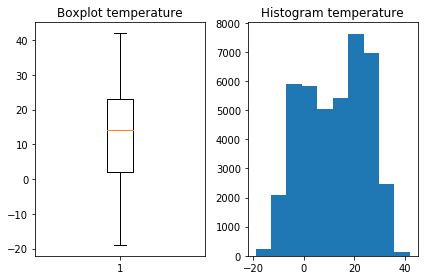

pressure outlier count 0 out of 41757


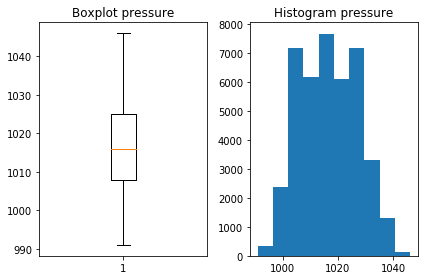

wind_speed outlier count 4893 out of 41757


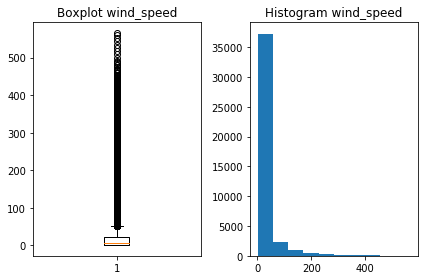

hours_snow outlier count 368 out of 41757


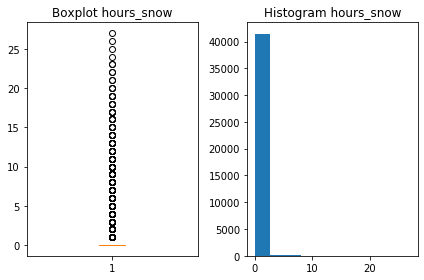

hours_rain outlier count 1739 out of 41757


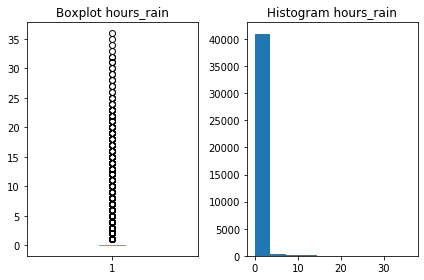

pm2.5 outlier count 1773 out of 41757


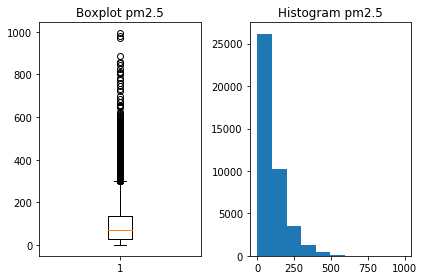

In [203]:
# Histogram / Box plot outlier analysis

for c in ["dew_point", "temperature", "pressure", 
          "wind_speed", "hours_snow", "hours_rain", 
          "pm2.5" ]:
    
    data = df[c]
    
    plt.subplot(1, 2, 1)
    plt.title("Boxplot " + c)
    boxPlotObject = plt.boxplot(data, showfliers=True)
    
    plt.subplot(1, 2, 2)
    plt.title("Histogram " + c)
    plt.hist(data)
    
    totalCount = len(data)
    outlierCount = outlier_count(boxPlotObject)
    print(f"{c} outlier count {outlierCount} out of {totalCount}")
    
    plt.tight_layout()
    plt.show()